In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/scortesg/Documents/risk_certificate')
sys.path.append('/usr0/home/naveenr/projects/risk_certificate')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 
from certificate.run_simulations import get_results_matching_parameters, aggregate_data
import seaborn as sns

In [4]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [34]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [62]:
colors_by_method = {}
non_adaptive_methods = ['','random','k_1','one_stage']
our_methods = ['sample_split','sample_split_total','prior','']
adaptive_methods = ['successive_elimination','ucb']

greys = plt.cm.Greys(np.linspace(0, 1, len(non_adaptive_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(our_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(adaptive_methods)))

for i,m in enumerate(non_adaptive_methods):
    colors_by_method[m] = greys[i]

for i,m in enumerate(our_methods):
    colors_by_method[m] = vidris[i]

for i,m in enumerate(adaptive_methods):
    colors_by_method[m] = wistia[i]

colors_by_method['omniscient'] = np.array([0.9,0.05,0.05,1.0])

In [66]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(non_adaptive_methods+our_methods+['omniscient']+adaptive_methods):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]

## AISTATS Plots

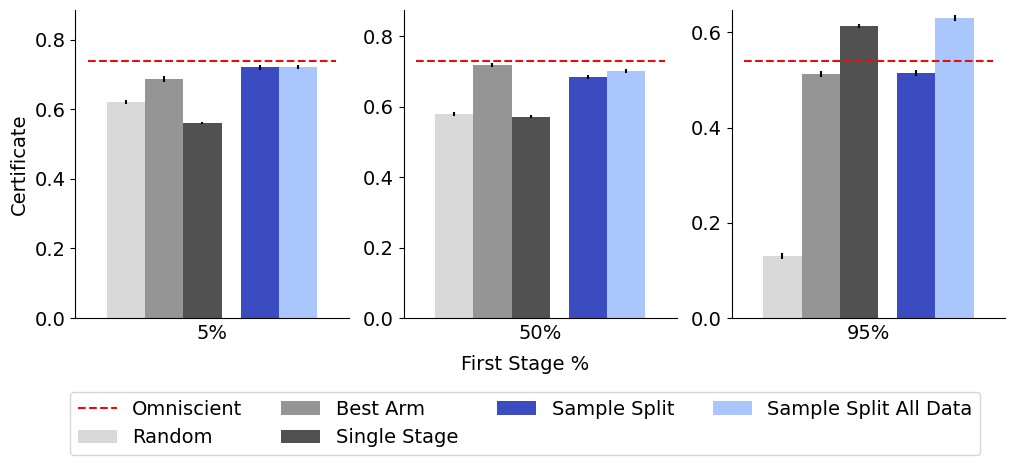

<Figure size 700x400 with 0 Axes>

In [63]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
method_names = ['random','k_1','one_stage','sample_split','sample_split_total','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Sample Split All Data","Omniscient"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'sample_size': 500}
dataset = "non_adaptive"
first_stage_sizes = [50,250,450]
first_stage_percent = ["5%","50%","95%"]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'sample_split':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(first_stage_sizes)):
    baseline_params['first_stage_size'] = first_stage_sizes[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random']['certificate'])
    results = aggregate_data(results)

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)

        if m == 'omniscient':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(first_stage_percent[i],fontsize=14)
        

axs[0].set_ylabel("Certificate",fontsize=14)
axs[2].set_yticks([0,0.2,0.4,0.6])

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.supxlabel("First Stage %",fontsize=14,x=0.5,y=-0.03)
fig.savefig("../../results/figures/non_adaptive.pdf",dpi=300, bbox_inches='tight')


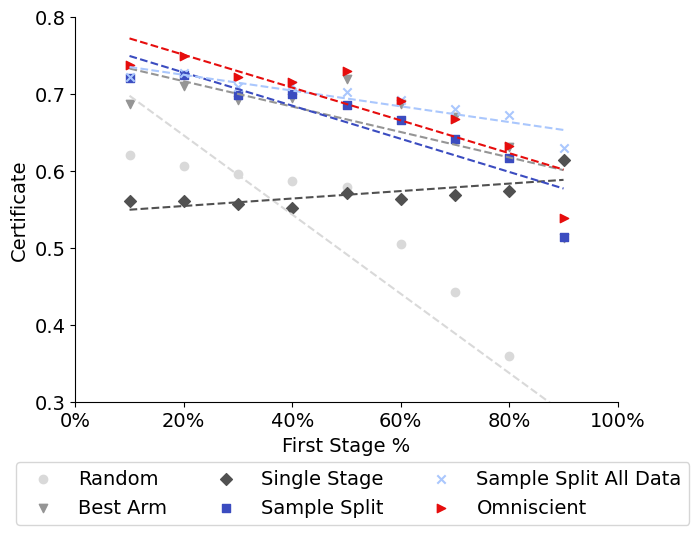

In [106]:
plt.figure(figsize=(7,5))
method_names = ['random','k_1','one_stage','sample_split','sample_split_total','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Sample Split All Data","Omniscient"]

first_stage_values = [50,100,150,200,250,300,350,400,450]
percents = [i/500 for i in first_stage_values]
baseline_params = {'sample_size': 500}

plots_by_method = {}
for m in method_names:
    plots_by_method[m] = []

for first_stage_value in first_stage_values:
    baseline_params['first_stage_size'] = first_stage_value
    dataset = "non_adaptive"
    results = get_results_matching_parameters(dataset,"",baseline_params)
    results = aggregate_data(results)
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}'.format(method_name)][0])

for i,m in enumerate(method_names):
    zipped_values = zip(percents,plots_by_method[m])
    zipped_values = [i for i in zipped_values if i[0] < 1.0]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    plt.plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])

plt.ylim([0.3,0.8])
plt.xticks([0,0.2,0.4,0.6,0.8,1],["0%","20%","40%","60%","80%","100%"])
plt.legend(fontsize=14,bbox_to_anchor=(1.15,-0.13),ncol=3)
plt.ylabel("Certificate")
plt.xlabel("First Stage %")
plt.savefig("../../results/figures/first_stage_percent.pdf",dpi=300, bbox_inches='tight')



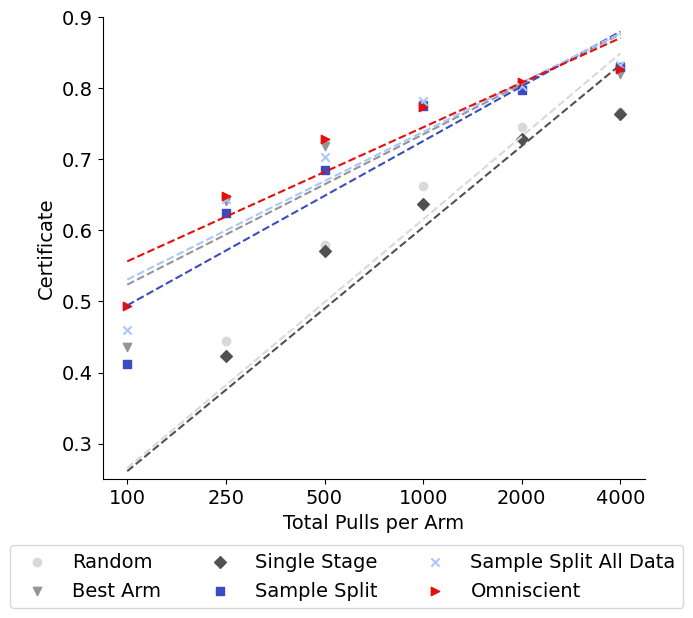

In [145]:
plt.figure(figsize=(7,6))
method_names = ['random','k_1','one_stage','sample_split','sample_split_total','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Sample Split All Data","Omniscient"]

total_stage_values = [100,250,500,1000,2000,4000]
baseline_params = {}

plots_by_method = {}
for m in method_names:
    plots_by_method[m] = []

for total_stage_value in total_stage_values:
    baseline_params['first_stage_size'] = total_stage_value//20*10
    baseline_params['sample_size'] = total_stage_value
    dataset = "non_adaptive"
    results = get_results_matching_parameters(dataset,"",baseline_params)
    results = aggregate_data(results)
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}'.format(method_name)][0])

for i,m in enumerate(method_names):
    zipped_values = zip(list(range(len(total_stage_values))),plots_by_method[m])
    zipped_values = [i for i in zipped_values]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    plt.plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])

plt.ylim([0.25,0.9])
plt.xticks(list(range(len(total_stage_values))),total_stage_values)
plt.legend(fontsize=14,bbox_to_anchor=(0.45,-0.3),ncol=3,loc='lower center')
plt.ylabel("Certificate")
plt.xlabel("Total Pulls per Arm")
plt.savefig("../../results/figures/total_pulls.pdf",dpi=300, bbox_inches='tight')



In [121]:
dataset = "vary_n_m"
# dataset = "temp"
# max_pulls_per_arm*n_arms
sample_size = 500*200
# first_stage_pulls_per_arm*n_arms
fs = 50*200
temp_params = {'number_arms': 200, 'sample_size': sample_size, 'first_stage_size': fs}#, 'max_pulls_per_arm': 50}#, 'first_stage_pulls_per_arm': 25}
results = get_results_matching_parameters(dataset,"",temp_params)
print(results)
results = aggregate_data(results)


[{'parameters': {'number_arms': 200, 'sample_size': 100000, 'first_stage_size': 10000, 'distribution': [0.1362989496646377, 0.13274817570706765, 0.1280898421636536, 0.1408861565059324, 0.1300488941765445, 0.11812785619440531, 0.14098710034554585, 0.8747136951862047, 0.1207556936240553, 0.14697517598385204, 0.1257120397046603, 0.11122881635735875, 0.13313138837812927, 0.14028070326424735, 0.13382756016463807, 0.830193759566925, 0.12085458626728318, 0.873937037067628, 0.835162393686162, 0.10205129085366799, 0.14340608672257407, 0.12770121923165503, 0.11778418363208493, 0.1143173055869926, 0.13995069661620688, 0.13235569353724896, 0.12126723193604584, 0.12379305646318316, 0.10982004749844315, 0.12585280164637408, 0.11683268714067326, 0.12092981946578454, 0.12108992879850135, 0.11302172621691947, 0.1273825623626446, 0.12348403244683841, 0.13121552556583557, 0.14038790858019154, 0.12821861230086776, 0.13562887112341476, 0.11776429110518719, 0.12851741517503576, 0.10313389554338892, 0.128572

Text(0.5, 1.0, 'Certificate value as a function of the numbers of arms chosen')

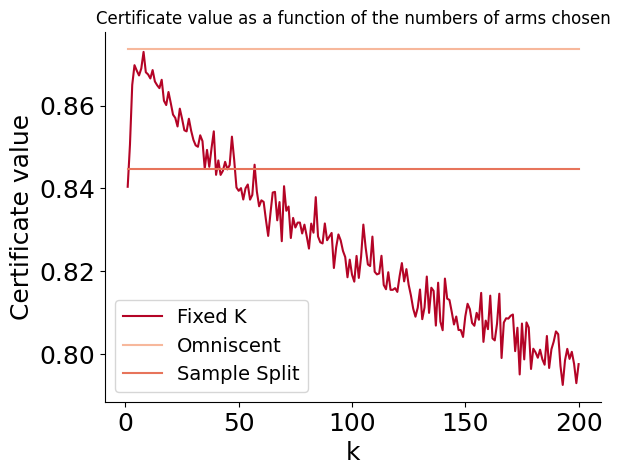

In [122]:
value_by_k = [results['k_{}'.format(i)][0] for i in range(1,temp_params['number_arms']+1)]
plt.plot(list(range(1,temp_params['number_arms']+1)),value_by_k,label='Fixed K',color=colors_by_method['fixed_k'])
plt.plot(list(range(1,temp_params['number_arms']+1)),[results['omniscient'][0] for i in range(0,temp_params['number_arms'])],label='Omniscent',color=colors_by_method['omniscient'])
plt.plot(list(range(1,temp_params['number_arms']+1)),[results['sample_split'][0] for i in range(0,temp_params['number_arms'])],label='Sample Split',color=colors_by_method['sample_split'])
plt.legend()
plt.xlabel('k')
plt.ylabel('Certificate value')
plt.title("Certificate value as a function of the numbers of arms chosen")


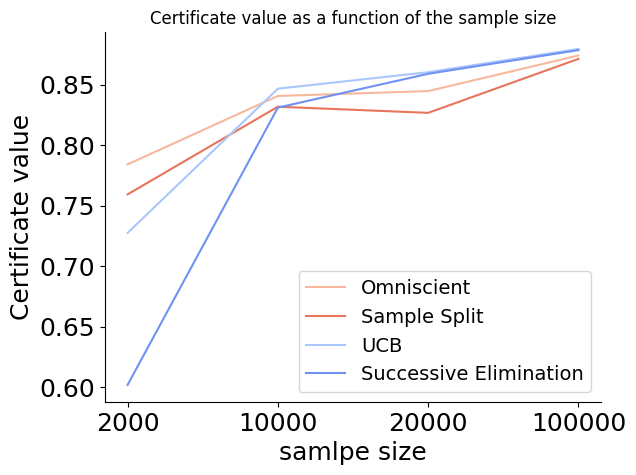

In [123]:
dataset = "vary_n_m"
number_arms = 200
sample_sizes = [200*10,200*50,200*100,200*500]

methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': number_arms}

for i in range(len(methods)):
    method_name = methods[i]
    nice_name = nice_names[i] 
    data = []

    for s in sample_sizes:
        # Make this consistent across classes
        temp_params['sample_size'] = s
        # if s == 2000:
        #     s = 8*200
        temp_params['first_stage_size'] = s // 2

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_data(results)
        data.append(results[method_name][0])
    plt.plot(list(range(len(sample_sizes))),data,label=nice_name,color=colors_by_method[method_name])

# Set y-axis ticks to the sample size numbers
plt.xticks(list(range(len(sample_sizes))), [str(size) for size in sample_sizes])
plt.xlabel('samlpe size')
plt.ylabel('Certificate value')
plt.title("Certificate value as a function of the sample size")

plt.legend()




Text(0.5, 13.52222222222222, 'Fraction initial stage')

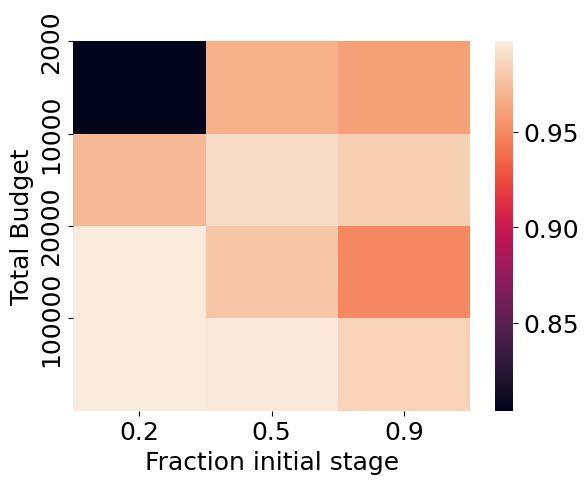

In [124]:
dataset = "vary_n_m"
# sample_sizes = [500,1000,5000]

# sample_sizes = [2000,10000,20000,100000]
number_arms = 200
sample_sizes = [200*10,200*50,200*100,200*500]
first_stage_sizes = [0.2,0.5,0.9]
# temp_params = {'number_arms': 10}
temp_params = {'number_arms': number_arms}

total_array = np.zeros((len(sample_sizes),len(first_stage_sizes)))

for i in range(len(sample_sizes)):
    for j in range(len(first_stage_sizes)):
        temp_params['sample_size'] = sample_sizes[i]
        temp_params['first_stage_size'] = int(first_stage_sizes[j]*sample_sizes[i])
        
        # if temp_params['first_stage_size'] == 125:
        #     temp_params['first_stage_size'] = 100

        # if temp_params['first_stage_size'] == 1250:
        #     temp_params['first_stage_size'] = 1000

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_data(results)
        
        total_array[i,j] = results['sample_split'][0]/results['omniscient'][0]

sns.heatmap(total_array)
plt.xticks([0.5,1.5,2.5],labels=first_stage_sizes)  # Set the tick labels
plt.yticks(range(len(sample_sizes)),labels=sample_sizes)
plt.ylabel("Total Budget")
plt.xlabel("Fraction initial stage")


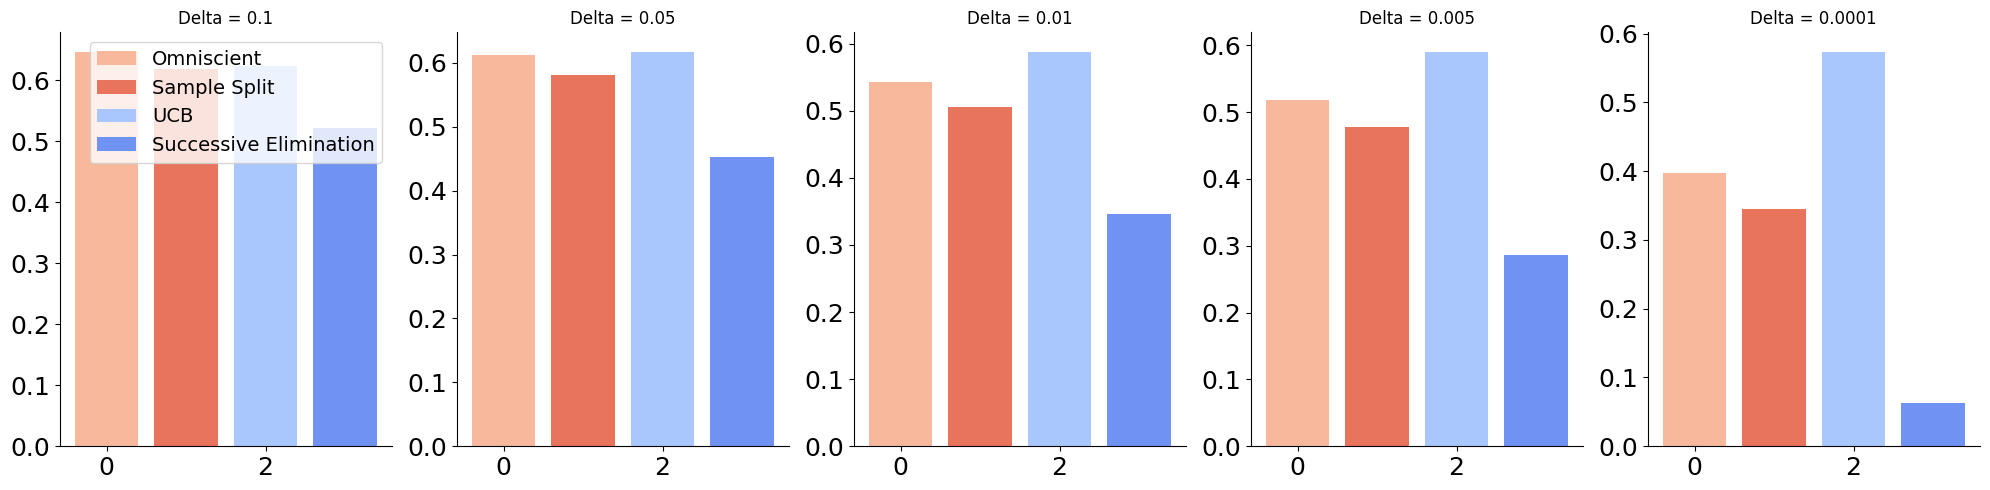

In [125]:
dataset = "vary_delta"
delta_values = [0.1,0.05,0.01,0.005,0.0001]
methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': 10, 'sample_size': 200, 'first_stage_size': 100}
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Adjust figsize as needed

for idx,delta in enumerate(delta_values):
    temp_params['delta'] = delta
    results = get_results_matching_parameters(dataset,"",temp_params)
    results = aggregate_data(results)
    values = [results[m][0] for m in methods]  # Extract the values for each method

    # Create a bar plot on the corresponding subplot
    axes[idx].bar(list(range(len(methods))), values, color=[colors_by_method[i] for i in methods],label=nice_names)
    axes[idx].set_title(f'Delta = {delta}')

axes[0].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



In [188]:
from scipy.stats import beta as beta_function

0.0

2 0.5 -0.7652789553347764 0.8 1.0107684172294822
4 1 -0.6362943611198908 0.8 1.0666300727615676


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8 2 -0.7949200872700217 0.8 1.0678422950455613
16 4 -1.062974403979176 0.8 1.0535526514469993


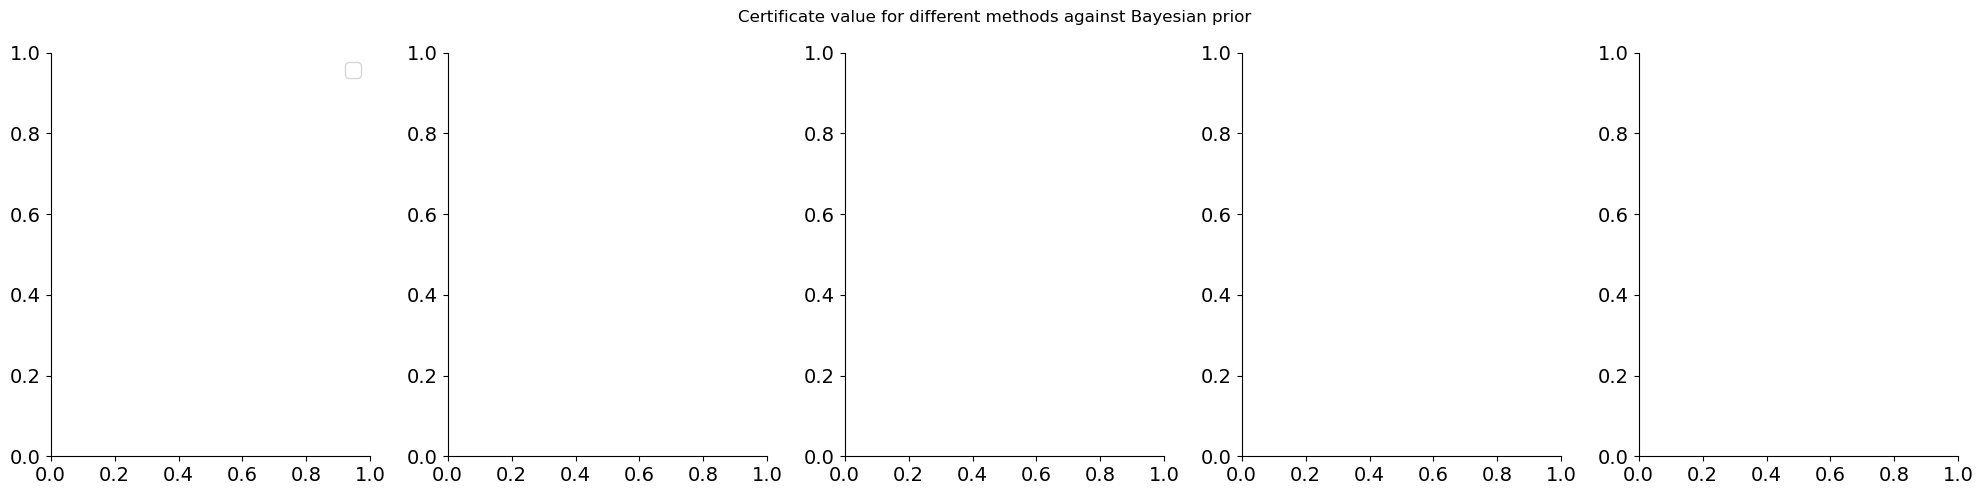

In [193]:
dataset = "prior_data"
alpha_beta_values = [(2,0.5),(4,1),(8,2),(16,4)]
methods = ['omniscient','sample_split','prior']
nice_names = ['Omniscient','Sample Split',"Prior"]
temp_params = {'number_arms': 10, 'sample_size': 500, 'first_stage_size': 250}
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Adjust figsize as needed

for idx,(alpha,beta) in enumerate(alpha_beta_values):
    temp_params['reward_parameters'] = {"alpha": float(alpha), "beta": float(beta), "diff_mean_1": 2, "diff_mean_2": 2, "diff_std_1": 2, "diff_std_2": 2}
    results = get_results_matching_parameters(dataset,"",temp_params)
    results = aggregate_data(results)
    values = [results[m][0] for m in methods]  # Extract the values for each method

    # Create a bar plot on the corresponding subplot
    # axes[idx].bar(list(range(len(methods))), values, color=[colors_by_method[i] for i in methods],label=nice_names)
    entropy = beta_function.entropy(alpha,beta)
    mean = (alpha)/(alpha+beta)
    print(alpha,beta,entropy,mean,results['prior'][0]/results['sample_split'][0])
    # axes[idx].set_title(entropy)
    # axes[idx].set_xticks([])
axes[0].legend()  

fig.suptitle("Certificate value for different methods against Bayesian prior")
# Adjust layout and display the plots

plt.tight_layout()
plt.show()



In [127]:
dataset = "vary_gaps"
sample_sizes = [500,1000,5000]
mu_1 = [0.01,0.02,0.05]
methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': 10,'sample_size': 500}

for i in range(len(methods)):
    method_name = methods[i]
    nice_name = nice_names[i] 
    data = []
    
    for s in mu_1:
        temp_params['diff_mean_1'] = s
        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_data(results)
        data.append(results[method_name][0])
    plt.plot(list(range(len(sample_sizes))),data,label=nice_name,color=colors_by_method[method_name])

plt.legend()



KeyError: 'omniscient'

In [88]:
dataset = "vary_gaps"
mu_1 = [0.01,0.02,0.05,0.1]
methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': 10,'sample_size': 500, 'diff_mean_2': 0.005}

for i in range(len(methods)):
    method_name = methods[i]
    nice_name = nice_names[i] 
    data = []
    
    for s in mu_1:
        temp_params['diff_mean_1'] = s
        results = get_results_matching_parameters(dataset,"",temp_params)
        print(s,len(results))
        results = aggregate_data(results)
        data.append(results[method_name][0])
    plt.plot(list(range(len(sample_sizes))),data,label=nice_name,color=colors_by_method[method_name])

plt.legend()



0.01 0


KeyError: 'omniscient'